# Data 604 - Final Exam Part 2

The second question I chose to solve comes from [chapter 19](https://github.com/AllenDowney/ModSimPy/blob/master/chapters/chap19.ipynb) of "Modelling and Simulation in Python", and involves simulating a low-pass filter.

In [1]:
# import functions from modsim

from modsim import *

The following circuit diagram (from [Wikipedia](https://commons.wikimedia.org/wiki/File:1st_Order_Lowpass_Filter_RC.svg)) shows a low-pass filter built with one resistor and one capacitor.  

![Circuit diagram of a low-pass filter](https://github.com/AllenDowney/ModSim/raw/main/figs/Lowpass_Filter_RC.png)

A "filter" is a circuit takes a signal, $V_{in}$, as input and produces a signal, $V_{out}$, as output.  In this context, a "signal" is a voltage that changes over time.

A filter is "low-pass" if it allows low-frequency signals to pass from $V_{in}$ to $V_{out}$ unchanged, but it reduces the amplitude of high-frequency signals.

By applying the laws of circuit analysis, we can derive a differential equation that describes the behavior of this system.  By solving the differential equation, we can predict the effect of this circuit on any input signal.

Suppose we are given $V_{in}$ and $V_{out}$ at a particular instant in time.  By Ohm's law, which is a simple model of the behavior of resistors, the instantaneous current through the resistor is:

$ I_R = (V_{in} - V_{out}) / R $

where $R$ is resistance in ohms.

Assuming that no current flows through the output of the circuit, Kirchhoff's current law implies that the current through the capacitor is:

$ I_C = I_R $

According to a simple model of the behavior of capacitors, current through the capacitor causes a change in the voltage across the capacitor:

$ I_C = C \frac{d V_{out}}{dt} $

where $C$ is capacitance in farads (F).

Combining these equations yields a differential equation for $V_{out}$:

$ \frac{d }{dt} V_{out} = \frac{V_{in} - V_{out}}{R C} $

Follow the instructions below to simulate the low-pass filter for input signals like this:

$ V_{in}(t) = A \cos (2 \pi f t) $

where $A$ is the amplitude of the input signal, say 5 V, and $f$ is the frequency of the signal in Hz.

## Params and System objects

Here's a `Params` object to contain the quantities we need.  I've chosen values for `R1` and `C1` that might be typical for a circuit that works with audio signal.

In [2]:
params = Params(
    R1 = 1e6,   # * ohm
    C1 = 1e-9,  # * farad
    A = 5,      # * volt
    f = 1000,   # * Hz
)
params

,values
R1,1.000000e+06
C1,1.000000e-09
A,5.000000e+00
f,1.000000e+03


Now we can pass the `Params` object `make_system` which computes some additional parameters and defines `init`.

* `omega` is the frequency of the input signal in radians/second.

* `tau` is the time constant for this circuit, which is the time it takes to get from an initial startup phase to 

* `cutoff` is the cutoff frequency for this circuit (in Hz), which marks the transition from low frequency signals, which pass through the filter unchanged, to high frequency signals, which are attenuated.

* `t_end` is chosen so we run the simulation for 4 cycles of the input signal.

In [3]:
from numpy import pi

def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    f, R1, C1 = params.f, params.R1, params.C1
    
    init = State(V_out = 0)
    omega = 2 * pi * f
    tau = R1 * C1
    cutoff = 1 / R1 / C1 / 2 / pi
    t_0 = 0
    t_end = 4 / f
    
    return System(params, 
                  init=init, 
                  t_0 = t_0,
                  t_end=t_end, num=401,
                  omega=omega, tau=tau, 
                  cutoff=cutoff)

Let's make a `System`

In [4]:
system = make_system(params)
system

,values
R1,1000000.0
C1,0.0
A,5.0
f,1000.0
init,V_out 0 dtype: int64
t_0,0
t_end,0.004
num,401
omega,6283.185307
tau,0.001


The system variable `num` controls how many time steps we get from `run_solve_ivp`.  The default is 101; in this case we increase it to 401 because the methods we'll use to analyze the results require high resolution in time.

**Exercise:** Write a slope function that takes as an input a `State` object that contains `V_out`, and returns the derivative of `V_out`.


In [5]:
def slope_func(state, t, system):
    
    V_out = state
    R, C = system.R1, system.C1
    
    V_in = system.A * np.cos(2 * np.pi * system.f * t)
    dV_outdt = (V_in - V_out) / (R * C)
    
    return dV_outdt

Test the slope function with the initial conditions.

In [6]:
slope_func(0, system.init, system)

V_out    5000.0
dtype: float64

And then run the simulation.  I suggest using `t_eval=ts` to make sure we have enough data points to plot and analyze the results. 

In [7]:
results, details = run_ode_solver(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

In [8]:
results.tail()

,V_out
0.00384,-0.590788
0.00388,-0.442612
0.00392,-0.266791
0.00396,-0.074366
0.00400,0.122578


Here's a function you can use to plot `V_out` as a function of time.

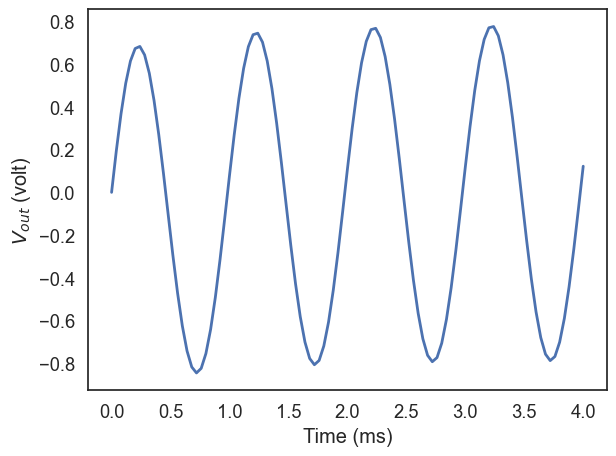

In [9]:
def plot_results(results):
    V_out = results.V_out.copy()
    t_end = results.index[-1]
    
    if t_end < 0.1:
        V_out.index *= 1000
        xlabel = 'Time (ms)'
    else:
        V_out = results.V_out
        xlabel = 'Time (s)'
        
    V_out.plot(label='_nolegend')
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)')
    
plot_results(results)

If things have gone according to plan, the amplitude of the output signal should be about 0.8 V.

Also, you might notice that it takes a few cycles for the signal to get to the full amplitude. 

## Sweeping frequency

Here's what `V_out` looks like for a range of frequencies:

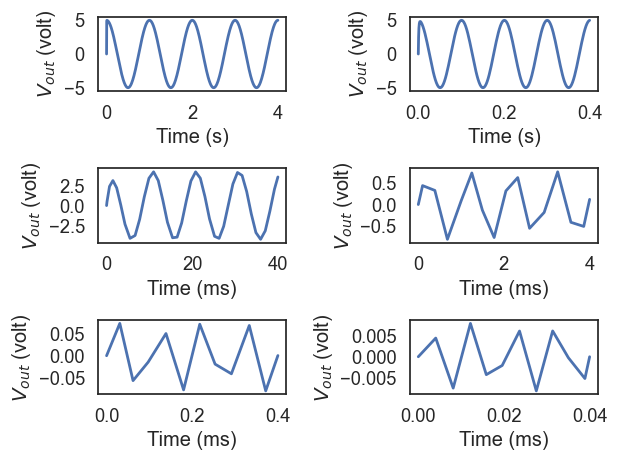

In [10]:
from matplotlib.pyplot import subplot

fs = [1, 10, 100, 1000, 10000, 100000]

for i, f in enumerate(fs):
    params.set(f=f)
    system = make_system(params)
    results, details = run_solve_ivp(system, slope_func)
    subplot(3, 2, i+1)
    plot_results(results)

At low frequencies, notice that there is an initial "transient" before the output gets to a steady-state sinusoidal output.  The duration of this transient is a small multiple of the time constant, `tau`, which is 1 ms.

## Estimating the output ratio

Let's compare the amplitudes of the input and output signals.  Below the cutoff frequency, we expect them to be about the same.  Above the cutoff, we expect the amplitude of the output signal to be smaller.

We'll start with a signal at the cutoff frequency, `f=1000` Hz.

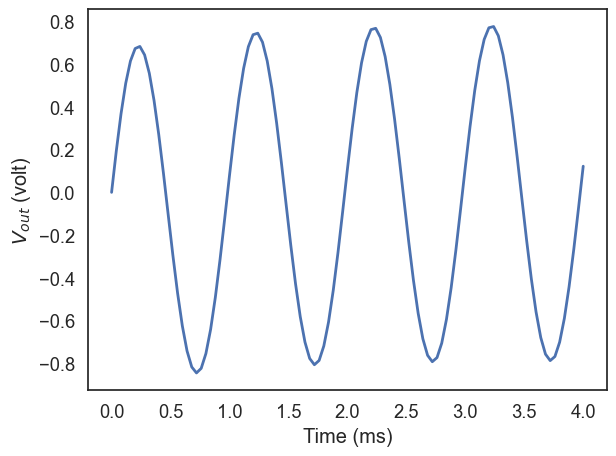

In [11]:
params.set(f=1000)
system = make_system(params)
results, details = run_ode_solver(system, slope_func)
V_out = results.V_out
plot_results(results)

The following function computes `V_in` as a `TimeSeries`:

In [12]:
def compute_vin(results, system):
    """Computes V_in as a TimeSeries.
    
    results: TimeFrame with simulation results
    system: System object with A and omega
    
    returns: TimeSeries
    """
    A, omega = system.A, system.omega
    
    ts = results.index
    V_in = A * np.cos(omega * ts)
    return TimeSeries(V_in, results.index, name='V_in')

Here's what the input and output look like.  Notice that the output is not just smaller; it is also "out of phase"; that is, the peaks of the output are shifted to the right, relative to the peaks of the input.

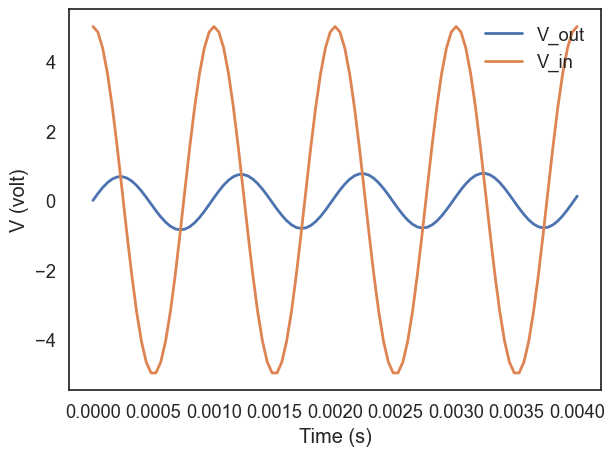

In [13]:
V_in = compute_vin(results, system)

V_out.plot()
V_in.plot()

decorate(xlabel='Time (s)',
         ylabel='V (volt)')

The following function estimates the amplitude of a signal by computing half the distance between the min and max.

In [14]:
def estimate_A(series):
    """Estimate amplitude.
    
    series: TimeSeries
    
    returns: amplitude in volts
    """
    return (series.max() - series.min()) / 2

The amplitude of `V_in` should be near 5 (but not exact because we evaluated it at a finite number of points).

In [15]:
A_in = estimate_A(V_in)
A_in

4.980286753286206

The amplitude of `V_out` should be lower.

In [16]:
A_out = estimate_A(V_out)
A_out

0.8117072523977684

And here's the ratio between them.

In [17]:
ratio = A_out / A_in
ratio

0.16298403939535594

**Exercise:** Encapsulate the code we have so far in a function that takes two `TimeSeries` objects and returns the ratio between their amplitudes.

In [18]:
def estimate_ratio(V_out, V_in):
    A_in = estimate_A(V_in)
    A_out = estimate_A(V_out)
    return A_out / A_in

And test your function.

In [19]:
estimate_ratio(V_out, V_in)

0.16298403939535594

## Estimating phase offset

The delay between the peak of the input and the peak of the output is call a "phase shift" or "phase offset", usually measured in fractions of a cycle, degrees, or radians.

To estimate the phase offset between two signals, we can use cross-correlation.  Here's what the cross-correlation looks like between `V_out` and `V_in`:

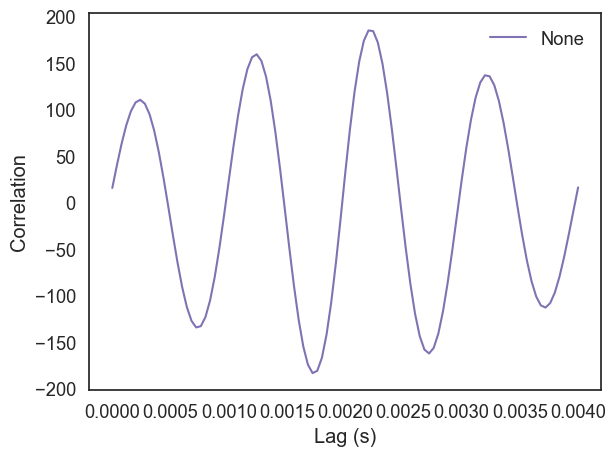

In [20]:
corr = np.correlate(V_out, V_in, mode='same')
corr_series = Series(index = V_in.index, data = corr)
corr_series.plot(color='C4')
decorate(xlabel='Lag (s)',
         ylabel='Correlation')

The location of the peak in the cross correlation is the estimated shift between the two signals, in seconds.

In [21]:
peak_time = corr_series.idxmax()
peak_time

0.002200000000000003

We can express the phase offset as a multiple of the period of the input signal:

In [22]:
period = 1 / system.f
period

0.001

In [23]:
peak_time / period

2.2000000000000033

We don't care about whole period offsets, only the fractional part, which we can get using `modf`:

In [24]:
frac, whole = np.modf(peak_time / period)
frac

0.2000000000000033

Finally, we can convert from a fraction of a cycle to degrees:

In [25]:
frac * 360

72.00000000000118

**Exercise:** Encapsulate this code in a function that takes two `TimeSeries` objects and a `System` object, and returns the phase offset in degrees.

Note: by convention, if the output is shifted to the right, the phase offset is negative.

In [26]:
def estimate_offset(V_out, V_in, system):
    corr = np.correlate(V_out, V_in, mode='same')
    corr_series = Series(index = V_in.index, data = corr)
    peak_time = corr_series.idxmax()
    period = 1 / system.f
    frac, whole = np.modf(peak_time / period)
    return -frac * 360 

Test your function.

In [27]:
estimate_offset(V_out, V_in, system)

-72.00000000000118